In [1]:
# for numerical computing
import numpy as np

# for dataframes
import pandas as pd

# for easier visualization
import seaborn as sns

# for visualization and to display plots
from matplotlib import pyplot as plt
%matplotlib inline

# import color maps
from matplotlib.colors import ListedColormap

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

from math import sqrt

# to split train and test set
from sklearn.model_selection import train_test_split

# to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import Ridge  # Linear Regression + L2 regularization
from sklearn.linear_model import Lasso  # Linear Regression + L1 regularization
from sklearn.svm import SVR # Support Vector Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Evaluation Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as rs
from sklearn.metrics import mean_absolute_error as mae

#import xgboost
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from xgboost import XGBRegressor
from xgboost import plot_importance  # to plot feature importance

# to save the final model on disk
from sklearn.externals import joblib

#  Feature Engineering

##  Indicator variables
* For example, let's say you knew that homes with 2 bedrooms and 2 bathrooms are especially popular for investors.
* Maybe you suspect these types of properties command premium prices. (You don't need to know for sure.)
* Create an indicator variable to flag properties with 2 beds and 2 baths and name it 'two_and_two'.

In [2]:
df = pd.read_csv('Files/stock_df.csv')

In [3]:
df['two_and_two'] = ((df.beds == 2) & (df.baths == 2)).astype(int)
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,...,college_grad,property_tax,insurance,median_school,num_schools,tx_year,s&p_returns,consumer_price_index,treasury_1_year_bond,two_and_two
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,Missing,0.0,...,84.0,234.0,81.0,9.0,3.0,2013,0.022121,0.015018,0.003387,0
1,240000,1,1,660,1983,0,Apartment / Condo / Townhouse,Brick,Missing,0.0,...,77.0,188.0,65.0,6.0,3.0,2013,0.022121,0.015018,0.003387,0
2,238600,1,1,834,1992,0,Apartment / Condo / Townhouse,Brick,Missing,0.0,...,66.0,185.0,61.0,2.0,3.0,2013,0.022121,0.015018,0.003387,0
3,371500,1,1,917,2007,0,Apartment / Condo / Townhouse,Concrete Block,Roll Composition,1.0,...,63.0,319.0,97.0,5.0,3.0,2013,0.022121,0.015018,0.003387,0
4,378000,1,1,961,2006,0,Apartment / Condo / Townhouse,Wood Siding,Missing,0.0,...,72.0,280.0,97.0,6.0,3.0,2013,0.022121,0.015018,0.003387,0


In [4]:
# Display percent of rows where two_and_two == 1
df[df['two_and_two']==1].shape[0]/df.shape[0]

0.09458023379383634

* The interpretation is that almost 9.5% of the observations in our dataset were for properties with 2 beds and 2 baths.
* People might also not take much interest in old properties.Lets figure it out.

In [5]:
df['old_properties'] = (df.year_built < 1980) .astype(int)

In [6]:
# Display percent of rows where old_properties == 1
df[df['old_properties']==1].shape[0]/df.shape[0]

0.3783209351753454

Create a new feature containing tax and insurance which a propery holder will have to pay monthly

In [7]:
df['tax_and_insurance'] = df.property_tax + df.insurance
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,...,insurance,median_school,num_schools,tx_year,s&p_returns,consumer_price_index,treasury_1_year_bond,two_and_two,old_properties,tax_and_insurance
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,Missing,0.0,...,81.0,9.0,3.0,2013,0.022121,0.015018,0.003387,0,0,315.0
1,240000,1,1,660,1983,0,Apartment / Condo / Townhouse,Brick,Missing,0.0,...,65.0,6.0,3.0,2013,0.022121,0.015018,0.003387,0,0,253.0
2,238600,1,1,834,1992,0,Apartment / Condo / Townhouse,Brick,Missing,0.0,...,61.0,2.0,3.0,2013,0.022121,0.015018,0.003387,0,0,246.0
3,371500,1,1,917,2007,0,Apartment / Condo / Townhouse,Concrete Block,Roll Composition,1.0,...,97.0,5.0,3.0,2013,0.022121,0.015018,0.003387,0,0,416.0
4,378000,1,1,961,2006,0,Apartment / Condo / Townhouse,Wood Siding,Missing,0.0,...,97.0,6.0,3.0,2013,0.022121,0.015018,0.003387,0,0,377.0


The interpretation is that almost 9.5% of the observations in our dataset were for properties with 2 beds and 2 baths.

### Example: housing market recession
According to data from Zillow, the lowest housing prices were from 2010 to end of 2013 (country-wide).
![title](Images/zillow-housing-prices.png)

Create a new feature called 'during_recession' to indicate if a transaction falls between 2010 and 2013

In [8]:
df['during_recession'] = ((df.tx_year >= 2010) & (df.tx_year <= 2013)).astype(int)

In [9]:
# Print percent of transactions where during_recession == 1
df[df['during_recession']==1].shape[0]/df.shape[0]

0.2635494155154091

## Interaction features

In [10]:
# Create a property age feature
df['property_age'] = df.tx_year - df.year_built

**Note:** 'property_age' denotes the age of the property when it was sold and not how old it is today, since we want to predict the price at the time when the property is sold.

Sanity Check: It's always nice to do a quick sanity check after creating a feature, which could save you headaches down the road. For example, 'property_age' should never be less than 0, right?

In [11]:
print(df.property_age.min())

-8


In [12]:
# Number of observations with 'property_age' < 0
print(sum(df.property_age < 0))

19


* On second thought, it's possible that some home owners bought houses before the construction company built them.
* This is not uncommon, especially with single-family homes.
* However, for this problem, **we are only interested in houses that already exist** because the REIT only buys existing ones!

In [13]:
# Remove rows where property_age is less than 0
df = df[df.property_age >= 0]
df.shape

(1863, 34)

Now, let's add another interaction feature. How about the number of quality schools nearby?
* We know the number of schools nearby 
* We also have their median quality score
* Let's use this and create a new feature

In [14]:
# Create a school score feature that num_schools * median_school
df['school_score'] = df.num_schools * df.median_school

In [15]:
# Display median school score
df.school_score.median()

18.0

*  As we can see almost all properties have basement, this feature won't affect the price of the property much, so we can remove it 

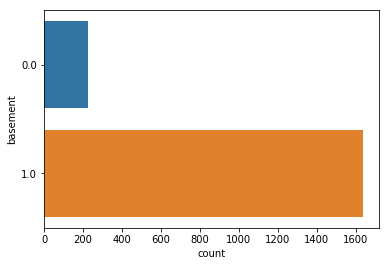

In [16]:
sns.countplot(y='basement', data=df)

In [17]:
#dropping the basement column
df = df.drop(['basement'], axis=1) 

* We can also delete some features which are less useful
* If we looked at the histogram of nightlife, almost all properties have nightlife within a mile also it has a poor relation with price of property(refer correlation part) so this feature might not be much useful do let's drop it.

In [18]:
df = df.drop(['nightlife'], axis=1)

##  Handling Sparse Classes
The easiest way to check for sparse classes is simply by plotting the distributions of your categorical features. We already did this during exploratory analysis, but since we've done some data cleaning since then, let's plot them again.

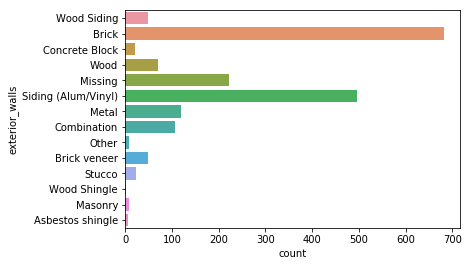

In [19]:
# Bar plot for exterior_walls
sns.countplot(y='exterior_walls', data=df)

In [20]:
df.exterior_walls.replace(['Wood Siding', 'Wood Shingle', 'Wood'], 'Wood', inplace=True)

In [21]:
other_exterior_walls = ['Concrete Block', 'Stucco', 'Masonry', 'Other', 'Asbestos shingle']
df.exterior_walls.replace(other_exterior_walls, 'Other', inplace=True)

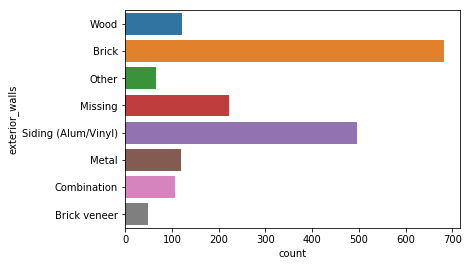

In [22]:
sns.countplot(y='exterior_walls', data=df)

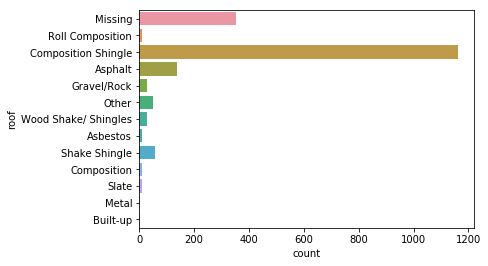

In [23]:
sns.countplot(y='roof', data=df)

In [24]:
df.roof.replace(['Composition', 'Wood Shake/ Shingles'], 'Composition Shingle', inplace=True)

In [25]:
other_roof = ['Other', 'Gravel/Rock', 'Roll Composition', 'Slate', 'Built-up', 'Asbestos', 'Metal']
df.roof.replace(other_roof, 'Other', inplace=True)

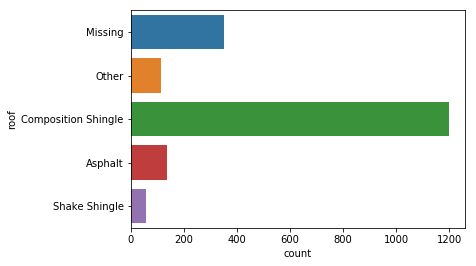

In [26]:
sns.countplot(y='roof', data=df)

In [27]:
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,restaurants,...,tx_year,s&p_returns,consumer_price_index,treasury_1_year_bond,two_and_two,old_properties,tax_and_insurance,during_recession,property_age,school_score
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood,Missing,107,...,2013,0.022121,0.015018,0.003387,0,0,315.0,1,0,27.0
1,240000,1,1,660,1983,0,Apartment / Condo / Townhouse,Brick,Missing,51,...,2013,0.022121,0.015018,0.003387,0,0,253.0,1,30,18.0
2,238600,1,1,834,1992,0,Apartment / Condo / Townhouse,Brick,Missing,45,...,2013,0.022121,0.015018,0.003387,0,0,246.0,1,21,6.0
3,371500,1,1,917,2007,0,Apartment / Condo / Townhouse,Other,Other,71,...,2013,0.022121,0.015018,0.003387,0,0,416.0,1,6,15.0
4,378000,1,1,961,2006,0,Apartment / Condo / Townhouse,Wood,Missing,54,...,2013,0.022121,0.015018,0.003387,0,0,377.0,1,7,18.0


## Encode dummy variables (One Hot Encoding)
* Machine learning algorithms cannot directly handle categorical features. Specifically, they cannot handle text values.
* Therefore, we need to create dummy variables for our categorical features.
* *Dummy variables* are a set of binary (0 or 1) features that each represent a single class from a categorical feature.

In [28]:
# Create a new dataframe with dummy variables for for our categorical features.
df = pd.get_dummies(df, columns=['exterior_walls', 'roof', 'property_type'])

**Note:** There are many ways to perform one-hot encoding, you can also use LabelEncoder and OneHotEncoder classes in SKLEARN or use the above pandas function.

In [29]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863 entries, 0 to 1881
Data columns (total 45 columns):
tx_price                                       1863 non-null int64
beds                                           1863 non-null int64
baths                                          1863 non-null int64
sqft                                           1863 non-null int64
year_built                                     1863 non-null int64
lot_size                                       1863 non-null int64
restaurants                                    1863 non-null int64
groceries                                      1863 non-null int64
cafes                                          1863 non-null int64
shopping                                       1863 non-null int64
arts_entertainment                             1863 non-null int64
beauty_spas                                    1863 non-null int64
active_life                                    1863 non-null int64
median_age            

##  Remove unused or redundant features
* Redundant features would typically be those that have been **replaced by other features** that you've added.
* For example, since we used 'tx_year' and 'year_built' to create the 'property_age' feature, we might consider removing them.


In [30]:
# Drop 'tx_year' and 'year_built' from the dataset
df = df.drop(['tx_year', 'year_built'], axis=1)  ## axis=1 because we are dropping columns.

In [31]:
df = df.drop(['property_tax', 'insurance'], axis=1)  ## axis=1 because we are dropping columns.

Finally, before we move on to the next module, let's save our new DataFrame we that augmented through feature engineering. We'll call it the analytical base table because we'll be building our models on it.
* Remember to set the argument index=None to save only the data.

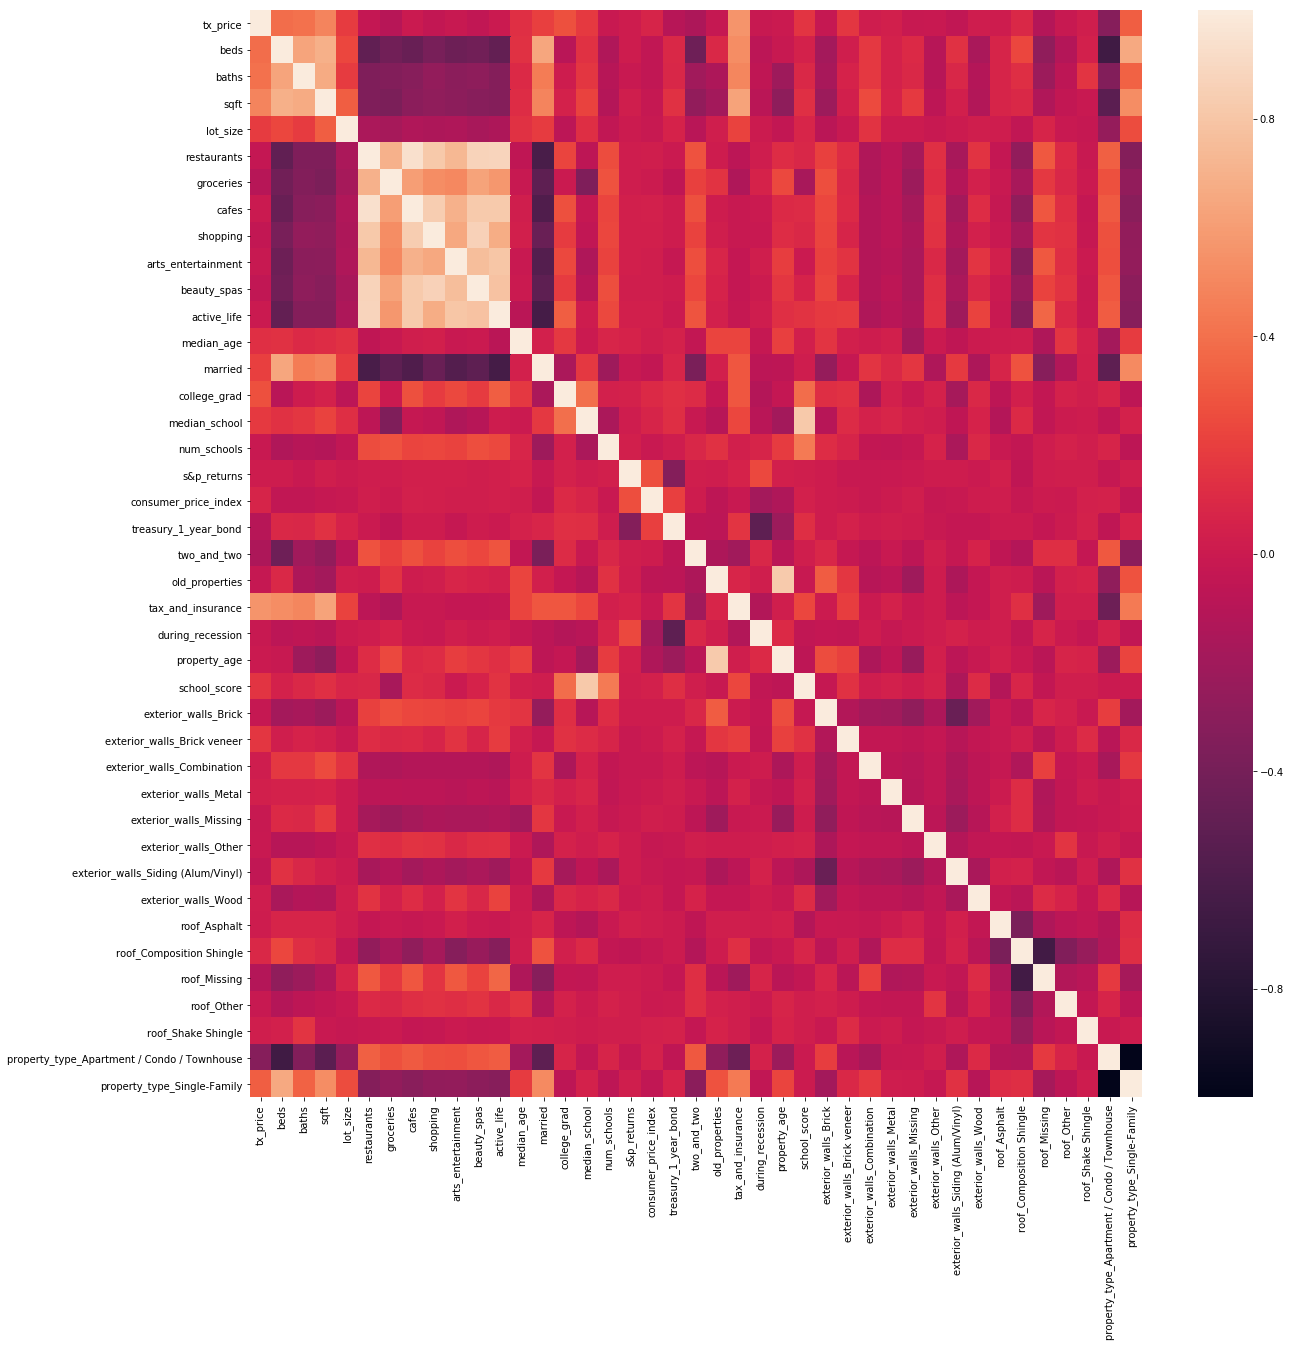

In [33]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr())
plt.savefig('heatmap.png')

**What to look for?**
* The colorbar on the right explains the meaning of the heatmap - Dark colors indicate **strong negative correlations** and light colors indicate **strong positive correlations**.
* Perhaps the most helpful way to interpret this correlation heatmap is to first find features that are correlated with our target variable by scanning the first column.
* In this case, it doesn't look like many features are strongly correlated with the target variable.

* Example: there is a strong negative correlation between beds and restaurants, or gloceries and median_schools.
* There is a weak positive correlation between 'tx_price' and 'property_tax'.

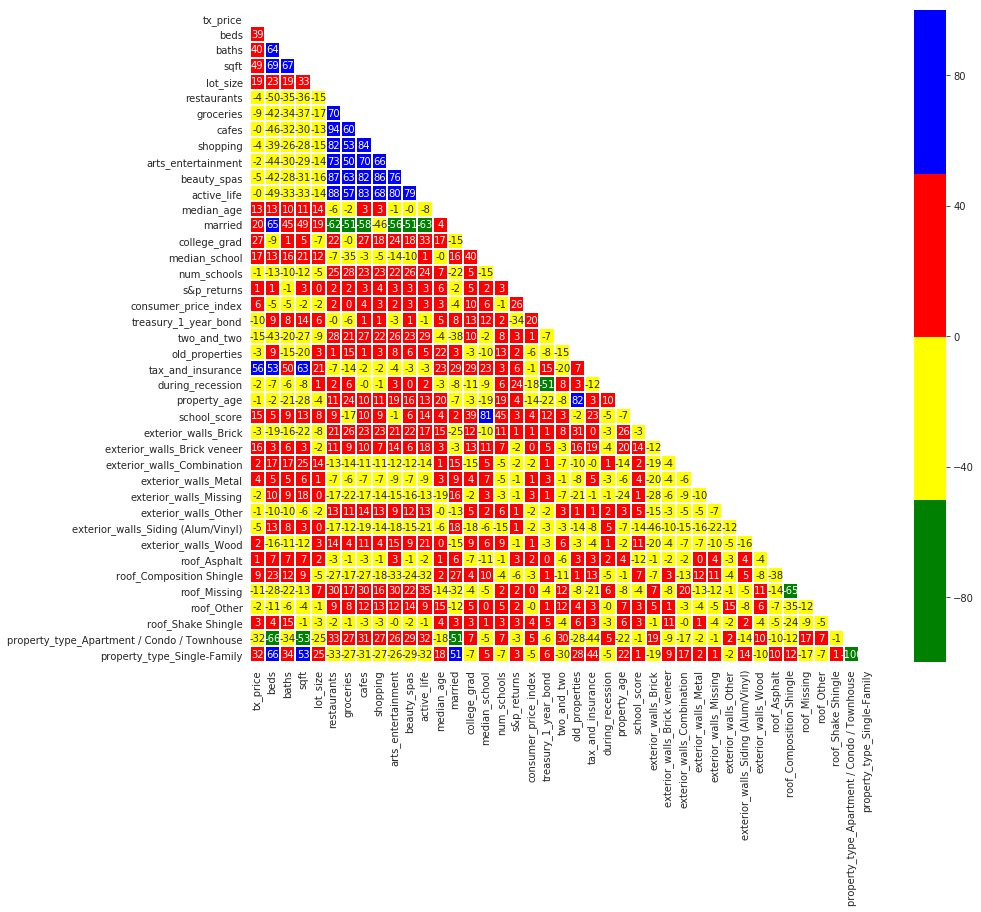

In [37]:
mask=np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(14,12))
with sns.axes_style("white"):
    ax = sns.heatmap(df.corr()*100, mask=mask, fmt='.0f', annot=True, lw=1, cmap=ListedColormap(['green', 'yellow', 'red','blue']))
    
plt.savefig('corr.png')    

In [38]:

# Save analytical base table
df.to_csv('Files/stock_analytical_base_table.csv', index=None)